# Dataset creation

#### First step in the project is to create the dataset we are going to work with.

In [1]:
import pandas as pd
import numpy as np
import copy
from tqdm import tqdm
import pickle
import seaborn as sns 
from collections import Counter
import matplotlib.pyplot as plt

#### We create a function to remove outliers in the dataset. We will use it when cleaning the data:

In [10]:
def outliers(data, column):
    # First quartile (Q1)
    Q1 = np.percentile(data[column], 25)
    # Third quartile (Q3)
    Q3 = np.percentile(data[column], 75)
    # Interquaritle range (IQR)
    IQR = Q3 - Q1
    down = Q1 - 1.5*IQR
    up =   Q3 + 1.5*IQR
    return data.loc[(data[column] < down) | (data[column] > up),
                column].index.values

#### Let's upload the dataset that contains the data of each apartment:

In [2]:
path = r"C:\Users\usuario\Desktop"
data = pd.read_csv(path + "/listings.csv", quotechar='"', engine = "python", encoding = "utf8")

#### Let's take a look at the columns:

In [5]:
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

#### The dataset contains 106 columns, most of which are links, descriptions or information we won't work with because they don't provide any useful information. We will remove these columns:

In [6]:
datos = data.drop(["experiences_offered", "listing_url", "thumbnail_url", "medium_url", "picture_url",
                   "xl_picture_url", "host_thumbnail_url", "host_picture_url", "jurisdiction_names",
                   "scrape_id", "last_scraped", "host_response_time", "name", "summary", "space", "description",
                   "neighborhood_overview", "notes", "transit", "access", "interaction",
                   "house_rules", "host_id", "host_url", "host_name","host_neighbourhood",  "host_location", "host_about",
                   "host_verifications", "street", "neighbourhood", "neighbourhood_cleansed",
                   "city", "state", "market", "zipcode", "smart_location", "country_code",
                   "country", "is_location_exact", "minimum_minimum_nights", "maximum_minimum_nights",
                   "minimum_maximum_nights", "maximum_maximum_nights", "minimum_nights_avg_ntm",
                   "maximum_nights_avg_ntm", "calendar_updated", "availability_30", "availability_60",
                   "availability_90", "calendar_last_scraped", "first_review", "last_review", "license",
                   "weekly_price", "monthly_price", "host_total_listings_count", "requires_license",
                   "is_business_travel_ready", "calculated_host_listings_count_entire_homes",
                   "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms",
                   "host_response_rate", "host_acceptance_rate"
                   ], 
                  axis = 1)

#### The dataset contains now 42 columns. We continue with the analysis to confirm if they are useful or they can be removed.

#### The next step is to transform the price columns from object to float type:

In [7]:
monetarias = ["price", "security_deposit", "cleaning_fee", "extra_people"]
for col in monetarias:
    datos[col] = datos[col].apply(lambda x: float(x.replace("$","").replace(",","")) if not pd.isnull(x) else np.nan)

#### Let's take a look at the prices:

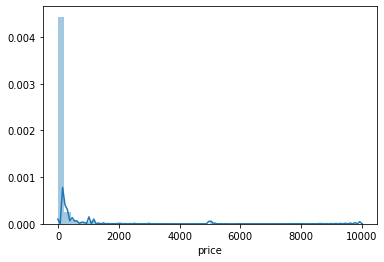

In [8]:
datos["price"].describe()
sns.distplot(datos["price"]) 

#### As we can see, there are some outliers that would have a big impact on our prediction. However, before removing them, we take a look at some of them to see if the price is real or if it's a mistake and it looks that there were some issues during the scrapping because the price is not in any case over 300 dollars.

#### We remove the outliers to have a much better prediction:

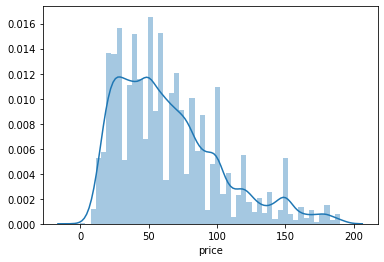

In [11]:
datos.drop(index=outliers(datos, "price"), inplace=True)
datos = datos.reset_index(drop = True)

datos["price"].describe()
sns.distplot(datos["price"]) 

#### We can clearly see that the distribution is much better now.

#### Now it's time to change those columns with True-False information to 1-0 :

In [12]:
datos['instant_bookable'] = datos['instant_bookable'].map({'f':0,'t':1})
datos['host_is_superhost'] = datos['host_is_superhost'].map({'f':0,'t':1})
datos['host_has_profile_pic'] = datos['host_has_profile_pic'].map({'f':0,'t':1})
datos['host_identity_verified'] = datos['host_identity_verified'].map({'f':0,'t':1})
datos['has_availability'] = datos['has_availability'].map({'f':0,'t':1})
datos['require_guest_profile_picture'] = datos['require_guest_profile_picture'].map({'f':0,'t':1})
datos['require_guest_phone_verification'] = datos['require_guest_phone_verification'].map({'f':0,'t':1})

#### Let's take a look now at the NaN in each column:

In [13]:
datos.isna().sum()

id                                      0
host_since                              3
host_is_superhost                       3
host_listings_count                     3
host_has_profile_pic                    3
host_identity_verified                  3
neighbourhood_group_cleansed            0
latitude                                0
longitude                               0
property_type                           0
room_type                               0
accommodates                            0
bathrooms                              15
bedrooms                               35
beds                                  294
bed_type                                1
amenities                               0
square_feet                         18945
price                                   0
security_deposit                     6106
cleaning_fee                         4593
guests_included                         0
extra_people                            0
minimum_nights                    

#### It's time to work with these NaNs. 
#### We will tackle this task following different procedures, based on the information they contain.

#### In these columns with 1-0 information, we will replace the NaNs with 0, guessing that if it doesn't contains the information, it means that it's false:

In [14]:
datos["host_is_superhost"].fillna(0, inplace=True)
datos["host_has_profile_pic"].fillna(0, inplace=True)
datos["host_identity_verified"].fillna(0, inplace=True)

In [ ]:
# In this case it's 1 because it's the number of apartments that the host has. It's at least one:
datos["host_listings_count"].fillna(1, inplace=True)

#### In the case of the security and the cleaning fee, we will supposed that if it's not provided, it's included in the price:

In [15]:
datos["security_deposit"].fillna(0.0, inplace=True)
datos["cleaning_fee"].fillna(0.0, inplace=True)

#### For the number of bedrooms and bathrooms, we will fill them with 1:

In [16]:
datos["bedrooms"].fillna(1, inplace=True)
datos["bathrooms"].fillna(1, inplace=True)

#### In the dataset, if the number of reviews is 0, the review_scores_rating, review_scores_accuracy... are NaNs, so will replace them by 0:

In [17]:
for fila in tqdm(range(datos.shape[0])):
    if (datos.loc[fila, "number_of_reviews"] == 0):
        datos.loc[fila, "review_scores_rating"] = 0
        datos.loc[fila, "review_scores_accuracy"] = 0
        datos.loc[fila, "review_scores_cleanliness"] = 0
        datos.loc[fila, "review_scores_checkin"] = 0
        datos.loc[fila, "review_scores_communication"] = 0
        datos.loc[fila, "review_scores_location"] = 0
        datos.loc[fila, "review_scores_value"] = 0
        datos.loc[fila, "reviews_per_month"] = 0

100%|███████████████████████████████████████████████████████████████████████████| 19221/19221 [00:22<00:00, 871.81it/s]


#### There are now 220 aprox. NaNs in the review's columns. Most of them have just one review and 0 in the last year, so we will replace all these cases with 0:

In [18]:
#quedan 220 aproximadamente, la gran mayoría con una única review y 0 en el último año, así que
#reemplzamos por 0 también
datos["review_scores_rating"].fillna(0, inplace=True)  
datos["review_scores_accuracy"].fillna(0, inplace=True)
datos["review_scores_cleanliness"].fillna(0, inplace=True)
datos["review_scores_checkin"].fillna(0, inplace=True)  
datos["review_scores_communication"].fillna(0, inplace=True) 
datos["review_scores_location"].fillna(0, inplace=True) 
datos["review_scores_value"].fillna(0, inplace=True)    

#### Let's take a look again at the NaNs to see what else should we do:

In [19]:
datos.isna().sum()

id                                      0
host_since                              3
host_is_superhost                       0
host_listings_count                     0
host_has_profile_pic                    0
host_identity_verified                  0
neighbourhood_group_cleansed            0
latitude                                0
longitude                               0
property_type                           0
room_type                               0
accommodates                            0
bathrooms                               0
bedrooms                                0
beds                                  294
bed_type                                1
amenities                               0
square_feet                         18945
price                                   0
security_deposit                        0
cleaning_fee                            0
guests_included                         0
extra_people                            0
minimum_nights                    

#### For the bad type, we will write the most common one:

In [20]:
datos["bed_type"].fillna('Real Bed', inplace=True)

#### In those rows with no date for the host registration, we will write the last date provided in the dataset:

In [21]:
datos["host_since"].fillna('2020-05-13', inplace=True)

#### In the case of the square feet, since this information can have a significant impact on the price, we will replace the NaNs with a -1, so that the algorithm can learn:

In [22]:
datos["square_feet"].fillna(-1, inplace=True)

#### Last column we should work on is the number of beds. We will fill it with the number of bedrooms that the apartment has: 

In [23]:
for fila in tqdm(range(datos.shape[0])):
    datos.loc[fila, "beds"] = datos.loc[fila, "bedrooms"]

100%|██████████████████████████████████████████████████████████████████████████| 19221/19221 [00:14<00:00, 1334.18it/s]


#### Let's check that there are no NaNs now:

In [24]:
datos.isna().sum()

id                                  0
host_since                          0
host_is_superhost                   0
host_listings_count                 0
host_has_profile_pic                0
host_identity_verified              0
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
beds                                0
bed_type                            0
amenities                           0
square_feet                         0
price                               0
security_deposit                    0
cleaning_fee                        0
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
has_availability                    0
availability

#### We will check now the column types to see if any modification should be performed:

In [25]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19221 entries, 0 to 19220
Data columns (total 42 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                19221 non-null  int64  
 1   host_since                        19221 non-null  object 
 2   host_is_superhost                 19221 non-null  float64
 3   host_listings_count               19221 non-null  float64
 4   host_has_profile_pic              19221 non-null  float64
 5   host_identity_verified            19221 non-null  float64
 6   neighbourhood_group_cleansed      19221 non-null  object 
 7   latitude                          19221 non-null  float64
 8   longitude                         19221 non-null  float64
 9   property_type                     19221 non-null  object 
 10  room_type                         19221 non-null  object 
 11  accommodates                      19221 non-null  int64  
 12  bath

#### Just the "host_since"column, that contains a date, should be changed. To make the analysis easier, we will use just the year instead of the whole date:

In [26]:
datos["host_since"] = pd.to_datetime(datos["host_since"]).dt.year

#### In a paralel analysis, we have worked on the amenities contained in the "amenities" column and the most significant ones have been selected. Let's upload the information to work with it:

In [27]:
with open(r"C:\Users\usuario\Desktop", "rb") as file:
    amen_elegidas = pickle.load(file)

#### To be able to work with each of these amenities, we create a column for each one, containing 1 if the apartment/room has this amenity or 0 if it doesn't:

In [28]:
for amenity in amen_elegidas:
    datos[amenity] = datos['amenities'].str.contains(amenity)
datos.drop(['amenities'], axis=1, inplace=True)
for amenity in amen_elegidas:
    datos[amenity] = datos[amenity].map({False:0,True:1})

#### For a deeper analysis of the columns we have in the dataset and their impact in the price, we have analyzed each one in Power BI and we have observed that some of them can be removed because they have no correlation with the price:

In [29]:
#Tras analizar los datos en PowerBI llegamos a la conclusión de que las siguientes columnas pueden 
#eliminarse también
datos = datos.drop(["beds", "translation missing: en.hosting_amenity_49",
                 "translation missing: en.hosting_amenity_50", "calculated_host_listings_count",
                 "has_availability", "host_has_profile_pic", "host_identity_verified",
                 "host_listings_count", "maximum_nights", "minimum_nights",
                 "number_of_reviews", "number_of_reviews_ltm", "Other","review_scores_accuracy", "review_scores_communication",
                 "review_scores_location", "review_scores_rating", "review_scores_value", "reviews_per_month",
                 "review_scores_checkin", "review_scores_cleanliness", "Bed linens", "First aid kit",
                 "Host greets you", "Pets allowed"], 
                 axis = 1)

#### As a final step we will save the dataset in a pickle to upload it easily when needed:

In [30]:
with open(r"C:\Users\usuario\Desktop", "wb") as file:
    pickle.dump(datos, file)